In [ ]:
import pandas as pd
import gzip
import json
import networkx as nx
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

WORKING_DIR = 'drive/MyDrive/dtsa5800_tweets_network_analysis'
DATA_DIR = f'{WORKING_DIR}/data'
DATA_FILE = f'{DATA_DIR}/nikelululemonadidas_tweets.jsonl.gz'

Mounted at /content/drive


## Twitter Mentions Network

- directed graph of twitter mentions
  - display Twitter users most closely related to the brand
  - depict how mentions flow on Twitter
<br>

- by follower count (influentials)
  - the most central users? for each brand
  - the most important bridgers? users who mention multiple or all three brands
<br>

- Pyvis

### unique users

In [ ]:
brands = ['nike', 'adidas', 'lululemon']
users = {}

with gzip.open(DATA_FILE) as f:
    for i, line in enumerate(f):
        tweet = json.loads(line)
        user = tweet['user']
        user_id = user['id']
        text = (tweet.get('full_text') or tweet.get('text') or '').lower()

        if any(brand in text for brand in brands):
            if user_id not in users:
                users[user_id] = {'id': user_id,
                                  'tweet_count': 0,
                                  'followers_count': user['followers_count'],
                                  'friends_count': user['friends_count']
                                  }
            users[user_id]['tweet_count'] += 1

matched_tweets = sum(user['tweet_count'] for user in users.values())
print(f'There are {i+1} tweets in this dataset.\n')
print(f'{matched_tweets} tweets mention any of the brankds {brands},')
print(f'posted by {len(users)} users.')


There are 175078 tweets in this dataset.

163286 tweets mention any of the brankds ['nike', 'adidas', 'lululemon'],
posted by 97437 users.


### bridgers

In [ ]:
user_brand_mentions = {}

with gzip.open(DATA_FILE, 'rt') as f:
    for line in f:
        tweet = json.loads(line)
        text = (tweet.get('full_text') or tweet.get('text') or '').lower()
        user_id = tweet['user']['id']
        screen_name = tweet['user']['screen_name']

        if user_id not in user_brand_mentions:
            user_brand_mentions[user_id] = {'screen_name': screen_name, 'nike': 0, 'adidas': 0, 'lululemon': 0}

        for brand in brands:
            if brand in text:
                user_brand_mentions[user_id][brand] += 1

bridgers = []
for user_id, info in user_brand_mentions.items():
    if all(count > 0 for brand, count in info.items() if brand != 'screen_name'):
        total_mentions = sum(info[brand] for brand in brands)
        bridgers.append((user_id, info['screen_name'], total_mentions, info['nike'], info['adidas'], info['lululemon']))

bridgers_sorted = sorted(bridgers, key=lambda x: x[2], reverse=True)[:10]

print(f"There are {len(bridgers)} bridgers in this tweets dataset who mention all three brands.\n")
print("Top 10 Bridgers based on total mentions:")
df = pd.DataFrame(bridgers_sorted, columns=['User ID', 'Screen Name', 'Total Mentions', 'Nike', 'Adidas', 'Lululemon'])
df

There are 81 bridgers in this tweets dataset who mention all three brands.

Top 10 Bridgers based on total mentions:


,User ID,Screen Name,Total Mentions,Nike,Adidas,Lululemon
0,989588511941578800,Kaya_Alexander5,736,723,12,1
1,1649250498,turtlepace5,391,321,68,2
2,333711651,HookTSB,99,86,12,1
3,21436676,FootwearNews,75,39,33,3
4,17842565,TheSportsIndex,54,30,13,11
5,299103961,TalkChannelNet,46,38,4,4
6,269040391,dnk900,32,14,16,2
7,16291894,DirectorJayC,29,26,1,2
8,19698834,MarketingEds,26,9,15,2
9,3348286709,DancingWillow78,19,9,1,9


Among these, 81 “bridgers” mentioned the three sports brands Nike, Adidas, and Lululemon, we can observe that Kaya_Alexander5 is the most active user, with 736 tweets related to these brands, primarily mentioning Nike.

This shows Nike's significant influence on social media, while also reflecting the engagement levels of other brands within different bridgers.

### selected users

In [ ]:
selected_user_ids = []

min_tweet_count = 2
min_followers_count = 1e5

for user_id, user in users.items():
    if user["tweet_count"] >= min_tweet_count and \
             user["followers_count"] >= min_followers_count:
        selected_user_ids.append(user_id)

print(f'{len(selected_user_ids)} users each have at least {min_tweet_count} tweets and {min_followers_count: .0f} followers.')
print(f'The selected users account for {(len(selected_user_ids)/len(users))*100: .2f} % of the total users.')

176 users each have at least 2 tweets and  100000 followers.
The selected users account for  0.18 % of the total users.


### mentions network

In [ ]:
graph = nx.DiGraph()

with gzip.open(DATA_FILE) as f:
    for i, line in enumerate(f):
        tweet = json.loads(line)
        sender_id = tweet["user"]["id"]
        sender_name = tweet["user"]["screen_name"]
        if sender_id in selected_user_ids:
            for mention in tweet["entities"]["user_mentions"]:
                receiver_name = mention["screen_name"]
                receiver_id = mention["id"]
                if receiver_id in selected_user_ids:
                    graph.add_edge(sender_name, receiver_name)

nodes = graph.number_of_nodes()
edges = graph.number_of_edges()
print(f"Graph has {nodes} nodes and {edges} edges.")
print(f"Among the selected users, {nodes} users have interactions involving {edges} mentions.")

Graph has 116 nodes and 190 edges.
Among the selected users, 116 users have interactions involving 190 mentions.


In [ ]:
def draw_network_graph(graph, figsize=(50, 40), node_size=800):
    pos = nx.spring_layout(graph, k=0.15, iterations=20)
    plt.figure(figsize=figsize)
    nx.draw_networkx(graph, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=node_size, width=1)
    plt.show()

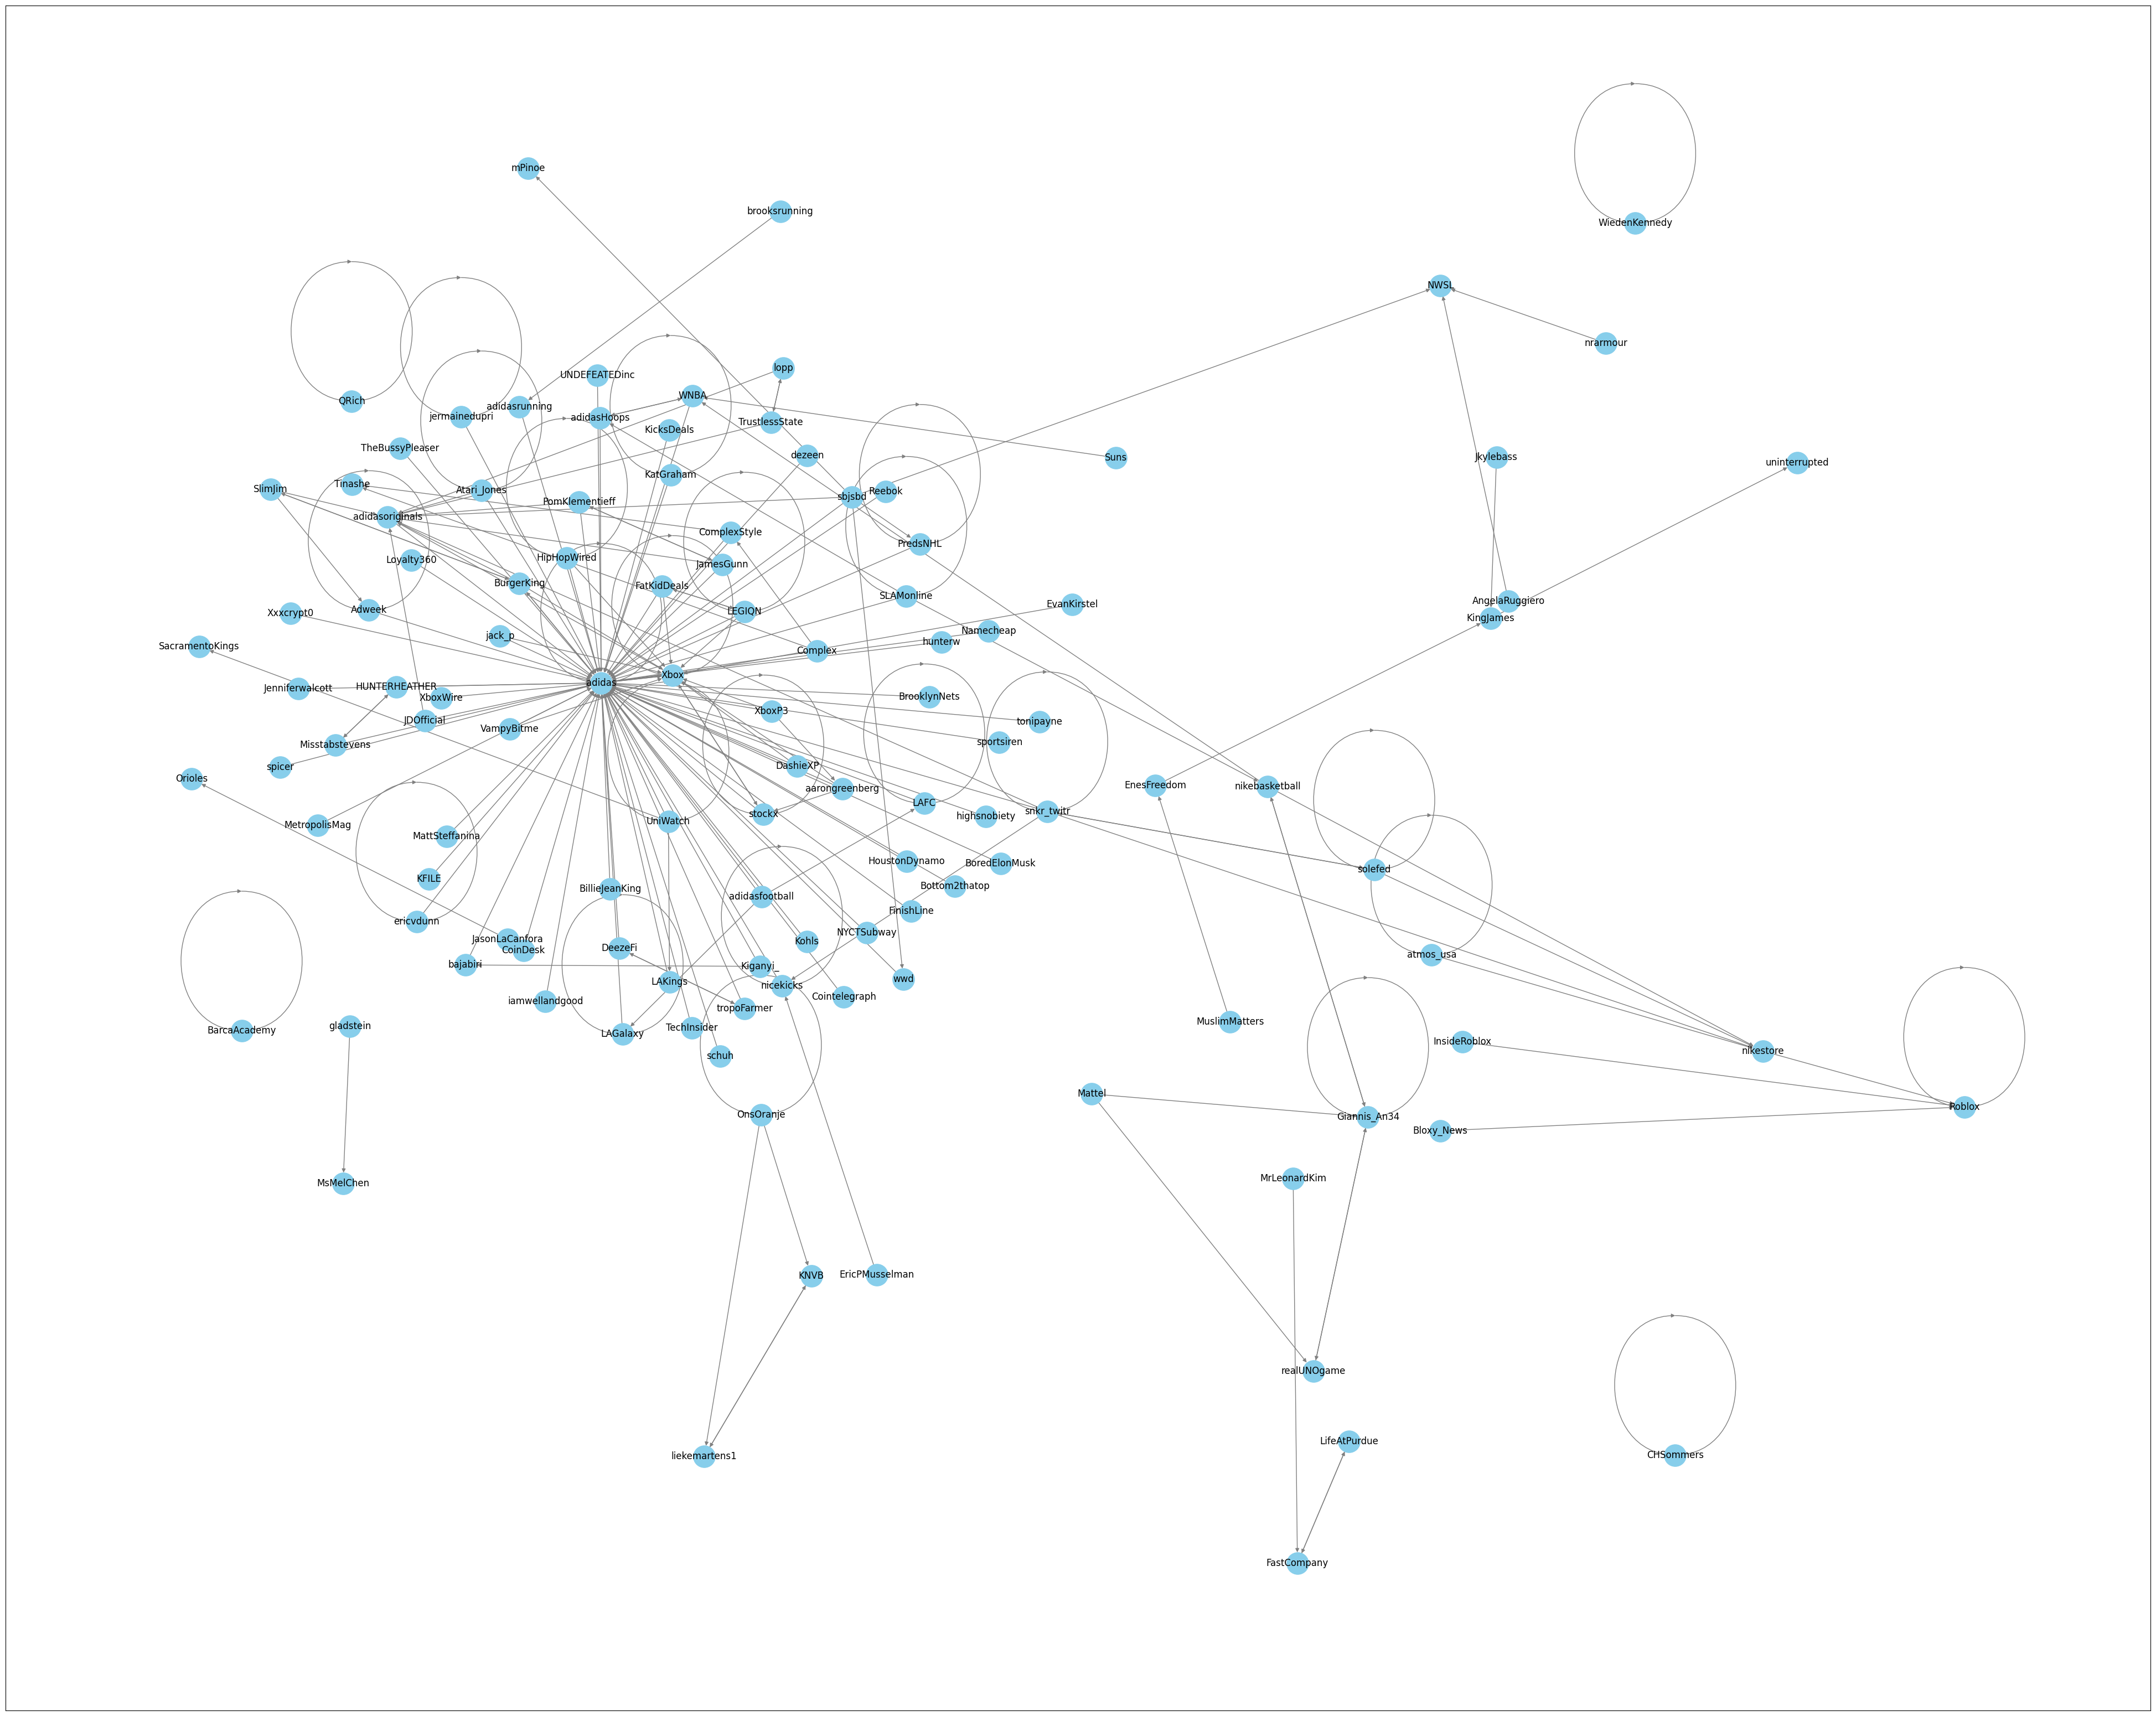

In [ ]:
draw_network_graph(graph)

In the analysis of the tweets mention network, among 97,437 users, there are 163,286 tweets mentioning the three sports brands.

And, 176 of these users are significantly influential, each has over 100,000 followers and actively engaging in brand mentions.

Among these interactions, adidas occupies a particularly critical central position in the network.

In [ ]:
# degree centrality
dc = nx.degree_centrality(graph)
sorted_dc = sorted(dc.items(), key=lambda x: x[1], reverse=True)

print("Top 10 most central nodes by degree centrality:\n")
for node, centrality in sorted_dc[:10]:
    print(f"{centrality: .4f} - {node}")

Top 10 most central nodes by degree centrality:

 0.6696 - adidas
 0.1478 - Xbox
 0.1043 - adidasoriginals
 0.0696 - snkr_twitr
 0.0609 - Giannis_An34
 0.0522 - LEGIQN
 0.0522 - stockx
 0.0522 - sbjsbd
 0.0522 - BurgerKing
 0.0435 - solefed


In [ ]:
# in degree centrality
idc = nx.in_degree_centrality(graph)
sorted_idc = sorted(idc.items(), key=lambda x: x[1], reverse=True)

print("In-degree Centrality:\n")
for node, centrality in sorted_idc[:10]:
    print(f"{centrality:.4f} - {node}")

# out degree centrality
odc = nx.out_degree_centrality(graph)
sorted_odc = sorted(odc.items(), key=lambda x: x[1], reverse=True)

print("\nOut-degree Centrality:\n")
for node, centrality in sorted_odc[:10]:
    print(f"{centrality:.4f} - {node}")


In-degree Centrality:

0.6435 - adidas
0.1130 - Xbox
0.0957 - adidasoriginals
0.0348 - nikestore
0.0348 - Giannis_An34
0.0348 - Roblox
0.0261 - WNBA
0.0261 - stockx
0.0261 - nicekicks
0.0261 - NWSL

Out-degree Centrality:

0.0522 - snkr_twitr
0.0522 - sbjsbd
0.0348 - Xbox
0.0348 - UniWatch
0.0348 - LEGIQN
0.0348 - SLAMonline
0.0348 - BurgerKing
0.0261 - adidas
0.0261 - Atari_Jones
0.0261 - solefed


The results above show that adidas has the highest in-degree centrality, indicating its strong influence on social media. Additionally, Xbox and adidasoriginals also have high mention frequencies.

In terms of out-degree centrality, snkr_twitr and sbjsbd (SportsBusiness Journal/SportsBusiness Daily) are the most active users, frequently mentioning other brands or users, showinging their high interaction engagement.